# MsPASS Getting Started Tutorial
## *Gary L. Pavlis, Indiana University and Yinzhi (Ian) Wang, TACC*

## Overview
This tutorial is intended as a first exercise to learn the key features of MsPASS.   It highlights how different types of standard seismology data are managed by the MsPASS database. It is limited to serial processing for simplicity.  There is an fundamental, followup tutorial called "parallel_processing_basics.ipynb" the focuses completely on the parallel frameworks used in MsPASS.  It is done as a separate tutorial as it could be run on an HPC cluster.   Note there are also additional followup tutorials in this directory on topics less fundamental to understanding how the system works.  

The approach is a quick overview.   Additional study will be needed to make the content seem less foreign;  this is only an overview tutorial.

## Preliminaries
This tutorial assumes you have already done the following:
1.  Installed docker.
2.  Run the commmand `docker pull mspass/mspass`
3.  In a terminal cd to the working directory where you saved this tutorial.
4.  Launched docker with this incantation:
```
  docker run -p 8888:8888 \
      --mount src=`pwd`,target=home,type=bind mspass/mspass
```
6.  Connected to the container to get this tutorial running as described in the __[User Manual](https://mspass.org)__.

Our user manual and github wiki pages give more details on how to do the above.  Go there if you have any issues.  This tutorial assumes that was completed and you are running this notebook while connected to MsPASS running within the docker container. 

## Download data with obspy
### Overview of this section
MsPASS leans heavily on obspy.  In particular, in this section we will use obspy's web services functions to download waveform data, station metadata, and source metadata.  The approach we are using here is to stage these data to your local disk.   The dataset we will assemble is the mainshock and 7 days of larger aftershocks of the Tohoku earthquake.  The next section then covers how we import these data into the MsPASS framework to allow them to be processed.

### Select, download, and save source data in MongoDB
As noted we are focusing on the Tohoku earthquake and its aftershocks.  That earthquake's origin time is approximately  March 11, 2011, at 5:46:24 UTC.  The ISC epicenter is 38.30N, 142.50E.  We will then apply obspy's *get_events* function with the following time and area filters:
1.  Starttime March 11, 2011, 1 hour before the origin time.
2.  End time 60 days after the mainshock origin time.
3.  Epicenters within + or - 3 degrees Latitude
4.  Epicenters within + or - 3 degrees of Longitude. 
5.  Only aftershocks larger than 6.5

Here is the incantation in obspy to do that:

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
t0=UTCDateTime('2011-03-11T05:46:24.0')
starttime=t0-3600.0
endtime=t0+(60.0)*(24.0)*(3600.0)
lat0=38.3
lon0=142.5
minlat=lat0-3.0
maxlat=lat0+3.0
minlon=lon0-3.0
maxlon=lon0+3.0
minmag=6.5

cat=client.get_events(starttime=starttime,endtime=endtime,
        minlatitude=minlat,minlongitude=minlon,
        maxlatitude=maxlat,maxlongitude=maxlon,
        minmagnitude=minmag)
print(cat)

13 Event(s) in Catalog:
2011-04-11T08:16:12.690000Z | +36.953, +140.584 | 6.7  MW
2011-04-07T14:32:44.100000Z | +38.251, +141.730 | 7.1  MW
...
2011-03-11T05:51:20.500000Z | +37.310, +142.240 | 6.8  None
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1  MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


We can save these easily into MongoDB for use in later processing with this simple command.

In [2]:
from mspasspy.db.database import Database
import mspasspy.client as msc
dbclient=msc.Client()
db = dbclient.get_database('getting_started')

In [3]:
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 13


### Select, download, and save station metadata to MongoDB
We use a very similar procedure to download and save station data.   We again use obspy but in this case we use their *get_stations* function to construct what they call an "Inventory" object containing the station data. 

In [4]:
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))
#print(inv)

Number of stations retrieved= 480


The output shows we just downloaded the data form 446 TA stations that were running during this time period. Note a detail is if you want full response information stored in the database you need to specify *level='response'* as we have here.  The default is never right.  You need to specify level as at least "channel". 

We will now save these data to MongoDB with a very similar command to above: 

In [5]:
ret=db.save_inventory(inv)
print('save_inventory returned value=',ret)

Database.save_inventory processing summary:
Number of site records processed= 481
number of site records saved= 481
number of channel records processed= 1452
number of channel records saved= 1446
save_inventory returned value= (481, 1446, 481, 1452)


This shows the use of the MsPASS `save_inventory` method of the `Database` class.  Obspy stores the information returned as "stationxml" format used in web services to transmit the information into a very complex python object (their `Inventory` object).  `save_inventory` translates that complex data structure to a simpler one required to as input for MongoDB.  Specifically, it has to create a "document" (aka python dictionary) of attributes stored in inventory.  `save_inventory` translates the inputs into "documents" it stores in two different collections:   (1) *site* for station information and (2) *channel* that contains most of the same data as *site* but add a set of important additional information (notably component orientation and response data).  To illustrate what that means, this incantation prints the first document stored in "site" collection:

In [6]:
from bson import json_util
doc=db.site.find_one({})
# this makes a prettier printout than a simple print
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "65db413b5e395d0be81037e9"
  },
  "loc": "",
  "net": "TA",
  "sta": "034A",
  "lat": 27.064699,
  "lon": -98.683296,
  "coords": [
    -98.683296,
    27.064699
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.683296,
      27.064699
    ]
  },
  "elev": 0.155,
  "edepth": 0.0,
  "starttime": 1262908800.0,
  "endtime": 1321574399.0,
  "site_id": {
    "$oid": "65db413b5e395d0be81037e9"
  }
}


### Download waveform data
The last download step for this tutorial is the one that will take the most time and consume the most disk space;  downloading the waveform data.   To keep this under control we keep only a waveform section spanning most of the body waves.   We won't burden you with the details of how we obtained the following rough numbers we use to define the waveform downloading parameters:

1.  The approximate distance from the mainshock epicenter to the center of the USArray in 2011 is 86.5 degrees.
2.  P arrival is expected about 763 s after the origin time
3.  S arrival is expected about 1400 s after the origin time

Since we have stations spanning the continent we will use the origin time of each event +P travel time (763 s) - 4 minutes as the start time.  For the end time we will use the origin time + S travel time (1400 s) + 10 minutes.  

This process will be driven by origin times from the events we downloaded earlier.   We could drive this by using the obspy *Catalog* object created above, but because the event data was previously saved to the database we will use this opportunity to illustrate how that data is managed in MsPASS.

First, let's go over the data we saved in MongoDB.  We saved the source data in a *collection* we call *source*.   For those familiar with relational databases a MongoDB "collection" plays a role similar to a table (relation) in a relational database.   A "collection" contains one or more "documents".  A "document" in MongoDB is analagous to a single tuple in a relational database.  The internal structure of a MongoDB is, however, very different being represented by binary storage of name-value pairs in a format they call BSON because the structure can be represented in human readable form as a common format today called JSON.   A key point for MsPASS to understand is that the BSON (JSON) documents stored in MongoDB map directly into a python dict container.   We illustrate that in the next box by printing the event hypocenter data we downloaded above and then stored in MongoDB:

In [7]:
from obspy import UTCDateTime
dbsource=db.source
cursor=dbsource.find().sort('time')   # This says to retrieve and iterator overall all source documents
# The Cursor object MongoDB's find function returns is iterable
print('Event in tutorial dataset')
doclist=list()
counter = 0
for doc in cursor:
    lat=doc['lat']
    lon=doc['lon']
    depth=doc['depth']
    origin_time=doc['time']
    mag=doc['magnitude']
    # In MsPASS all times are stored as epoch times. obspy's UTCDateTime function easily converts these to 
    # a readable form in the print statment here but do that only for printing or where required to 
    # interact with obspy
    print(counter,lat,lon,depth,UTCDateTime(origin_time),mag)
    doclist.append(doc)
    counter += 1 

Event in tutorial dataset
0 38.2963 142.498 19.7 2011-03-11T05:46:23.200000Z 9.1
1 37.31 142.24 33.0 2011-03-11T05:51:20.500000Z 6.8
2 38.9847 143.4632 20.0 2011-03-11T06:08:32.540000Z 6.7
3 36.2274 141.088 25.4 2011-03-11T06:15:37.570000Z 7.9
4 36.0692 142.1388 23.0 2011-03-11T06:18:51.060000Z 6.6
5 36.0675 141.7291 23.0 2011-03-11T06:20:02.390000Z 6.5
6 38.051 144.6297 19.8 2011-03-11T06:25:50.740000Z 7.6
7 36.1862 141.6639 26.0 2011-03-11T08:19:27.470000Z 6.5
8 39.2219 142.5316 18.9 2011-03-11T11:36:40.030000Z 6.5
9 38.8 142.2 33.0 2011-03-11T19:46:35.300000Z 6.5
10 37.5898 142.7512 24.8 2011-03-12T01:47:16.160000Z 6.5
11 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z 7.1
12 36.9529 140.5842 13.3 2011-04-11T08:16:12.690000Z 6.7


The next step is to download the waveform data for these events from IRIS via web services.  We will do that here through obspy's "bulk download" procedure, but be warned this is currently (early 2024) very slow.  If you run this box you can expect it to take between and hour and a hour and a half.  The box below is disabled by default to allow you to rerun this workflow with changes without needing to go through the lengthy download.   If you are running this for the first time, select the box below, then from the top bag change "Raw" to "Code".  

In [8]:
# note: it took me about 4100 s to download 13 events.
download_time=4100.0
bytes_downloaded = 1.463e9
transfer_rate=bytes_downloaded/download_time
print("Transfer rate for internet download=",transfer_rate)

Transfer rate for internet download= 356829.26829268294


Note we saved the output above as a set of "miniseed" format files.  The files are 
bundles of data with one file per event.   i.e. when this is finished you 
will see three files in the "wf" directory with the file names that the
script prints as it progresses.  There are other options for saving data 
in MsPASS we will explore later, but we use miniseed at this stage because 
it is advised as an the best current structure for initial construction of 
a working data set.  There are two reason for this
1.   The default behavior for obspy's miniseed writer uses compression.  That reduces disk storage for the raw data to approximately 1 byte per sample.
2.   Miniseed is minimally self-contained.  By that we mean it contains sufficient embedded Metadata that the information in the files can be reconstructed without an external index.

The dark side of miniseed is we need to index the data in the files we just 
downloaded to manage the information.  Fortunately, MsPASS has a fast 
algorithm to do that process.  The next step is to build an index to the 
files that we store in MongoDB in a "collection" we call `wf_miniseed`.  This next box creates that index. 

In [9]:
import os
# remove the comment below if you need to restart this workflow 
# at this point 
#db.drop_collection('wf_miniseed')
dir = './wf'
with os.scandir('./wf') as entries:
    for entry in entries:
        if entry.is_file():
            print('Building wf_miniseed index documents for file=',entry.name)
            db.index_mseed_file(entry.name,dir=dir)
        

Building wf_miniseed index documents for file= Event_0.msd
Building wf_miniseed index documents for file= Event_1.msd
Building wf_miniseed index documents for file= Event_10.msd
Building wf_miniseed index documents for file= Event_11.msd
Building wf_miniseed index documents for file= Event_12.msd
Building wf_miniseed index documents for file= Event_2.msd
Building wf_miniseed index documents for file= Event_3.msd
Building wf_miniseed index documents for file= Event_4.msd
Building wf_miniseed index documents for file= Event_5.msd
Building wf_miniseed index documents for file= Event_6.msd
Building wf_miniseed index documents for file= Event_7.msd
Building wf_miniseed index documents for file= Event_8.msd
Building wf_miniseed index documents for file= Event_9.msd


Let's have a look at what a typical entry for this "index" we just created.  We will use a method of the MsPASS `Database` class called `find_one` in combination with a utility called `json_util` to make the content more readable. 

In [10]:
from bson import json_util
doc=db.wf_miniseed.find_one({})
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "65db413f5e395d0be8103d8f"
  },
  "sta": "034A",
  "net": "TA",
  "chan": "BHE",
  "sampling_rate": 40.0,
  "delta": 0.025,
  "starttime": 1302510295.0,
  "last_packet_time": 1302511691.175,
  "foff": 0,
  "nbytes": 49152,
  "npts": 59081,
  "endtime": 1302511772.025,
  "storage_mode": "file",
  "format": "mseed",
  "dir": "/home/wf",
  "dfile": "Event_0.msd",
  "time_standard": "UTC"
}


There is a lot of stuff there, but a few key points are worth noting at this point:
1.  This is our first example of what a "document" is in MongoDB.  The python bindings for MongoDB (called `pymongo`) return MongoDB "documents" in python dict containers.  The `json_util` utility we used is appropriate because "json" is a commonly used format for defining such data (key-value pairs).
2.  The keys for most of the attributes are relatively self-explanatory, although many are abbreviations (e.g. "foff" is a common shorthand for "file offset" and is used to provide random access to a data file.)
3. These documents define an index to identify data stored in the files we just created because is stores the four attributes dir, dfile, foff, and nbytes define the chunk of the file that defines the data for a time segment defined by the seed station codes (net, sta, chan and, loc) along with the time interval defined by "starttime" to "endtime".

To see the above better here is a fancier table produced from a few the first 10 documents in `wf_miniseed`.   It illustrates a useful approach with MongoDB for user's familiar with python's pandas api and the use of MongoDB's equivalent of a "select" clause in SQL:

In [11]:
import pandas as pd
projection = {
    "net" : True,
    "sta" : True,
    "chan" : True,
    "starttime" : True,
    "dir" : True,
    "dfile" : True,
    "foff" : True,
    "nbytes" : True,
}

doclist=[]
cursor=db.wf_miniseed.find({},projection).limit(10)
for doc in cursor:
    doclist.append(doc)
df = pd.DataFrame.from_dict(doclist)
print(df)

                        _id   sta net chan     starttime    foff  nbytes  \
0  65db413f5e395d0be8103d8f  034A  TA  BHE  1.302510e+09       0   49152   
1  65db413f5e395d0be8103d90  034A  TA  BHN  1.302510e+09   49152   49152   
2  65db413f5e395d0be8103d91  034A  TA  BHZ  1.302510e+09   98304   53248   
3  65db413f5e395d0be8103d92  035A  TA  BHE  1.302510e+09  151552   65536   
4  65db413f5e395d0be8103d93  035A  TA  BHN  1.302510e+09  217088   65536   
5  65db413f5e395d0be8103d94  035A  TA  BHZ  1.302510e+09  282624   65536   
6  65db413f5e395d0be8103d95  035Z  TA  BHE  1.302510e+09  348160   65536   
7  65db413f5e395d0be8103d96  035Z  TA  BHN  1.302510e+09  413696   65536   
8  65db413f5e395d0be8103d97  035Z  TA  BHZ  1.302510e+09  479232   65536   
9  65db413f5e395d0be8103d98  109C  TA  BHE  1.302510e+09  544768   64512   

        dir        dfile  
0  /home/wf  Event_0.msd  
1  /home/wf  Event_0.msd  
2  /home/wf  Event_0.msd  
3  /home/wf  Event_0.msd  
4  /home/wf  Event_0.msd  
5

## Quick Look for QC
MsPASS has some basic graphics capabilities to display its standard data types.  We refer the reader to a the *BasicGraphics* tutorial for more details, but for now we will just illustrate using the plotting for a quick look as a basic QC to verify we have what we were looking for.

The previous step used *save_data* to save the data we downloaded to MongoDB.   How it is stored is a topic for later, but here we'll retrieve some of that data and plot it to illustrate the value of abstracting the read and write operations.   Reading is slightly more complicated than writing one atomic object as we did above.  The reason is that we often want to do a database select operation to limit what we get.  This example illustrates some basics on MongoDB queries.  The reader is referred to extensive external documentation on MongoDB (books and many online sources) on this topic and the [MsPASS User's Manual](https://mspass.org)

Let's first read the vertical component for one station from all the events we saved.   This is a good illustration of the basic query mechanism used by MongoDB.  It also illustrates the concept of an *Ensemble* (Readers familiar with seismic reflection processing can view an Ensemble as a generic form of "gather".) which means a group of related data bundled together.  First run the following code block.  Explanations of what is done and what it should teach are in the text block that follows.

In [12]:
sta='234A'
chan='BHZ'
query={ 'sta' : sta, 'chan' : chan }
ensemble_md=query
n=db.wf_miniseed.count_documents(query)
print('Trying to retrieve ',n,' TimeSeries objects for station=',sta,' for channel=',chan)
curs=db.wf_miniseed.find(query).sort('starttime')
ensemble=db.read_data(curs,collection='wf_miniseed',ensemble_metadata=ensemble_md)
print('Success:  number of members in this ensemble=',
      len(ensemble.member))
print('python type of ensemble symbol=',type(ensemble))
print('Ensemble header (Metadata container) contents=',ensemble)


Trying to retrieve  13  TimeSeries objects for station= 234A  for channel= BHZ
Success:  number of members in this ensemble= 13
python type of ensemble symbol= <class 'mspasspy.ccore.seismic.TimeSeriesEnsemble'>
Ensemble header (Metadata container) contents= {'chan': 'BHZ', 'sta': '234A'}


Starting at the top this algorithm can be broken up into four steps:
1.  The first two lines generate a query construct for MongoDB.  This example is a single, simple equality matching for one station and channel name using the seed code.
2.  Line 3 is not essential but illustrates a best practice for this example.   MsPASS ensemble objects contain a *Metadata* container that can be used to stored attributes common to the entire group.  Since this is a common station gather driven by a specific SEED station code, a logical way to define that is with that name (234A).  
3.  Lines 4-6 show a typical query construct with MongoDB using the `Database.count_documents` and `Database.find` method.  The use of `count_documents` is optional, but is generally a good idea to summarize what is being read.   The `Database.find` method returns a concept that may not be familiar to all readers of a "Database cursor".  There are many online sources that will give you details, but the key idea is to think of it as an iterator that accesses database "Documents" as if they were a list of python dictionaries (documents).  It isn't really a list, but it just acts that way as it defines an iterator than can only go forward.   That is, unlike a list a Cursor cannot be subscripted.  It can only be traversed from start to end.  We also used a sort clause to assure the contents are retrieved in time order.
4.  Line 7 show a typical MsPASS construct to read data.  All MsPaSS seismic data objects can be constructed through a call to the `Database.read_data` that is a variant of the above.  In this case we are reading and "ensemble".  When the reader detects arg0 is a cursor it assumes it should construct an ensemble from the documents it can retrieve through that cursor.  We add a couple of special arguments.  The `collection` argument is required in this case because the default will not try to read from a `wf_miniseed` but a `wf_TimeSeries` collection.   The `ensemble_metadata` argument is optional and is used as noted above.  That is, it tells the reader the contents of the python dictionary `ensemble_md` are Metadata common to the entire group.  That argument causes them to be posted in a container common to the ensemble. 
6.  That last group of lines are optional print statements but useful here to clarify the basics of what was read and illustrate typical QC print statements you may need in assembling a dataset.  The last line may seen a bit weird as one might expect a very large output from a print of the entire ensemble.   The example illustrates that what it does instead is only print the header data (the ensemble's *Metadata* container content).  

In addition to the educational point of a how to read data, this example also illustrates a key concept in MsPASS.   We define two data objects as *Atomic* that we refer to as *TimeSeries* and *Seismogram*.
As the one print statement above shows the symbol *ensemble* is what we call a *TimeSeriesEnsemble*.   It is a container that has an attribute called *member* that is itself a vector of  *TimeSeries* objects.  *TimeSeries* objects are an abstraction of the single channel records downloaded with FDSN web services.   Later in this tutorial we will convert the data associated with the wf_TimeSeries database collection to *Seismogram* objects and write them into a wf_Seismogram collection.  We call *Timeseries* and *Seismogram* object "Atomic" because for most processing they should be considered a single thing.  (For more experienced programs, note that in reality like atoms these data objects are made of subatomic particles with a class inheritance structure but the energy barrier to pull them apart is significant.)  Many functions, however, need the concept we call an *Ensemble*.   They should be used to group a set of atomic objects together that have a generic relationship.   Examples are "shot gather", "CMP gather", and "common receiver gather" concepts used in seismic reflection processing.  With passive array data the two most common groups are those associated with a single event and collections of all data recording a particular time period.  An *Ensemble* provides a generic way to hold any of those.  Your workflow needs to be aware at all times what is in any ensemble and be sure the requirements of an algorithm are met.  (e.g. in reflection processing you will get junk if you think an ensemble is an NMO corrected CMP gather and the data are actually a raw shot gather).  We reiterate that there are two named types of ensemble containers; one for each atomic data object.  They are called *TimeSeriesEnsemble* and *SeismogramEnsemble* for containers of *TimeSeries* and *Seismogram* object respectively.   In both cases the seismic data components are stored in simple vector container defined with the symbol *member*. The "vector" in this context is more generic than something like a numpy array.   We use the C++ std::vector generic concept that the member symbol can be subscripted with a "random access iterator".   That means you can use randomly access a single TimeSeries object in the above example with a construct like this:

d = ensemble.member[4]

and python can fetch that instance in equal time for random access.
The container also can act a bit like a python dict to store global metadata related to the ensemble. We will refer to that container here as the *ensemble metadata*.   Our example above can be thought of as a common receiver gather for TA station 234A.  Hence, we post that name with the key *sta* with the line `ensemble['sta']=sta`.    That model should be the norm for any ensemble.   That is, the ensemble metadata should normally contain a set of one or more key-value pairs that at least provide a  hint at the ensemble contents.  Here that is the station name, but we could add other data like the stations coordinates.  We defer that to below where that data becomes necessary. 

With that background let's plot these data.  Here we illustrate the use of basic plotting routines in MsPASS but we note any python graphic package can be use for plotting these data if you understand the data structures.  We provide the *SeismicPlotter* class here as a convenience.  A valuable addition for community development is extensions of our basic graphics module or alternative plotting modules.

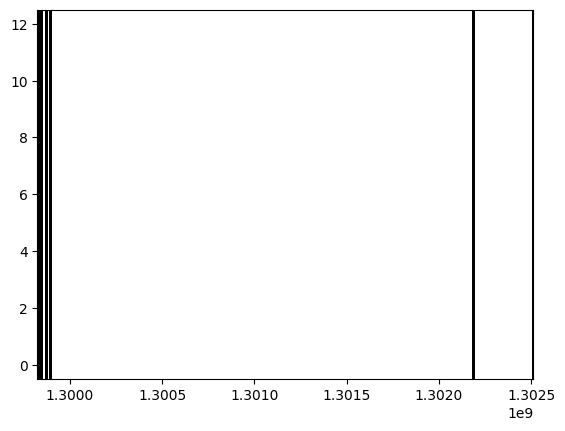

In [13]:
from mspasspy.graphics import SeismicPlotter
plotter=SeismicPlotter()
# TODO  default wtvaimg has a bug and produces a 0 height plot - wtva works for now
plotter.change_style('wt')
plotter.plot(ensemble)

Again, about as simple as it gets.  This and the earlier examples illustrate a key design goal we had for MsPASS:  make the package as simple to use for beginners as possible.   Simple doesn't always work, however, and experienced users will recognize that getting graphics right nearly always requires some tuning.  In this case, there are two issues.  The first is scaling.  The default in MsPASS is to do no scaling on plots assuming it is better if you control the algorithms to do that to get what you want.   The default assumes the signals all have amplitude of order 1, which is not remotely close to the actual sample data values.  The solution is to apply a scaling algorithm.  There are a rich collection of scaling options in the MsPASS `scale` function.  Here we use RMS.  We also set the "level" which means the rms amplitude each signal will be scaled to.   The magic number below was derived from rerunning the box below multiple times.  Feel free to do that yourself to understand that behavior.  

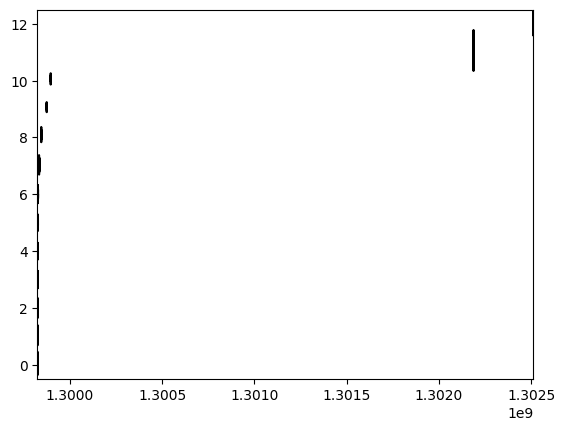

In [14]:
from mspasspy.algorithms.window import scale
ensemble = scale(ensemble,method='rms',level=0.1)
plotter.plot(ensemble)

We aren't there yet, which is typical of graphics.  The plots shows the mainshock record as the bottom 3 signals. Above that are sets of 3 components from the other 2 selected events in our data subset defined as "keepers". Notice how the 3 sets of signals are offset in time (the x-axis). The mainshock is y=0 box is the mainshock and the other boxes are the aftershocks.  The data are plotted that way because the data time stamp is coordinated universal time (UTC) and they are being plotted in their actual timing position. The boxes are artifact of plotting the entire signal in short space.  An interesting educational point is that the boxes time-relationship define a classic empirical relationship for aftershocks called [Omori's Law](https://en.wikipedia.org/wiki/Aftershock), although here as the cumulative distribution.  In this case, that is clearly not a very good way to view these data. MsPASS has a generic solution to this common issue and is the topic of next section.

The SeismicPlotter has a fair amount of additional functionality. See the BasicGraphics tutorial to learn some of that functionality.

## UTC and Relative Time
A unique feature of MsPASS is that we aimed to make it generic by supporting multiple time standards.  MsPASS currently supports two time standards we refer to with the name keys *UTC* and *Relative*.   The first, *UTC*, is well understood by all seismologists who work with any modern data.  UTC is a standard abbreviation for "coordinated univeral time", which is the time standard used on all modern data loggers.  It is important to recognize that unlike obspy we store all UTC times internally as "unix epoch times".  Epoch times are the number of seconds in UTC since the first instant of the year 1970.  We use only epoch times internally as it vastly simplifies storage of time attributes since they can be stored as a standard python float (always a 64 bit real number in python) that causes no complications in storage to MongoDB.  It also vastly simpifies computing time differences, which is a very common thing in data processing.   To convert UTC times to a human readable form we suggest using the obspy UTCDateTime class as we did above.  The inverse (converting a UTC date string to an epoch time) is simple with the `timestamp` method of UTCDateTime.  Some wrapped obspy functions require UTCDateTime objects but all database times are stored as floats. Most obspy function, like the web service functions we used above, use the UTCDateTime class to define times.  The point is be to be cautious about what time arguments mean to different functions.

The idea of a *Relative* time is well known to anyone who has done seismic reflection processing.   Experienced SAC users will also understand the concept through a different mechanism that we generalize.  Time 0 for seismic reflection data ALWAYS means the time that the "shot" was fired.  That is a type example of what we mean by *Relative* time.   Times are "relative" to the shot time and 0 is the shot time.  Earthquake data can be converted to the same concept by setting time zero time for each signal to the origin time of the event.   SAC users will recognize that idea as the case of the "O" definition of the data's time stamp.   Our *Relative* time, in fact, is a generalization of SAC's finite set of definitions for the time stamp for one of their data files like Tn, B, O, etc.   *Relative* just means the data are relative to some arbitrary time stamp that we refer to internally as *t0_shift*.  It is the user's responsibility to keep track of what *t0_shift* means for your data and whether that reference is rational for the algorithm being run.  We stress, however, that TimeSeries and Seismogram objects do keep track of *t0_shift* internally.  The time reference can be shifted to a different meaning if desired through combinations of three different methods:  *rtoa* (switch from Relative to Absolute=UTC), *ator* (switch from Absolute(UTC) to Relative), and *shift* that is used to apply a relative time shift.  In particular, when used correctly any relative time data can be restored to UTC by simply called the *rtoa* method or using the *rota* wrapper function.

In this next block we take the ensemble we created above and apply a time shift to put 0 at a constant time shift from the origin time of each event.  

In [15]:
from obspy import UTCDateTime
from mspasspy.ccore.seismic import TimeSeriesEnsemble
# We make a deep copy with this mechanism so we can restore raw data later
enscpy=TimeSeriesEnsemble(ensemble)
i=0
for d in ensemble.member:
    print('member ',i,' input t0 time=',UTCDateTime(d.t0))
    d.ator(d.t0)
    print('member ',i,' after running ator has time 0=',d.t0)
    i+=1

member  0  input t0 time= 2011-03-11T05:55:06.000000Z
member  0  after running ator has time 0= 0.0
member  1  input t0 time= 2011-03-11T06:00:03.024998Z
member  1  after running ator has time 0= 0.0
member  2  input t0 time= 2011-03-11T06:17:15.024998Z
member  2  after running ator has time 0= 0.0
member  3  input t0 time= 2011-03-11T06:24:20.000000Z
member  3  after running ator has time 0= 0.0
member  4  input t0 time= 2011-03-11T06:27:34.024998Z
member  4  after running ator has time 0= 0.0
member  5  input t0 time= 2011-03-11T06:28:45.024998Z
member  5  after running ator has time 0= 0.0
member  6  input t0 time= 2011-03-11T06:34:33.024998Z
member  6  after running ator has time 0= 0.0
member  7  input t0 time= 2011-03-11T08:28:10.024998Z
member  7  after running ator has time 0= 0.0
member  8  input t0 time= 2011-03-11T11:45:23.024998Z
member  8  after running ator has time 0= 0.0
member  9  input t0 time= 2011-03-11T19:55:18.024998Z
member  9  after running ator has time 0= 0.0


Notice how the times changed from an offset from the origin time we used for downloading to 0.   We can see this effect graphically in the next box.  

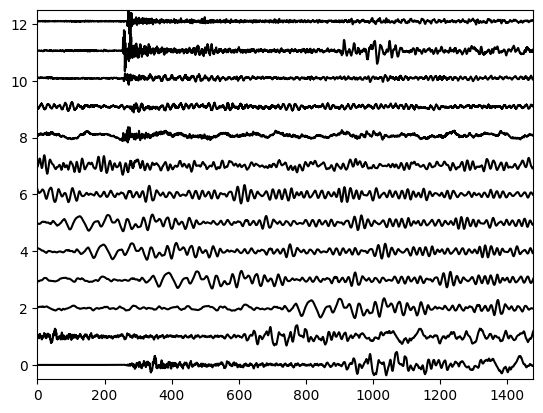

In [16]:
plotter.plot(ensemble)

Note that now the time axis starts at 0, BUT that is Relative time.  Here that time is a fixed offset from the origin time we obtained from an input list of hypocenter locations.   

Those signals are a little ugly because the the smaller event has some contamination from frequencies above 1 Hz.  There is also a typical dc offset problem that is the norm for raw data.   We'll fix both with a simple bandpass filter.  We'll put the low corner very low (around 500 s period) because the mainshock is rich in very low frequencies.  

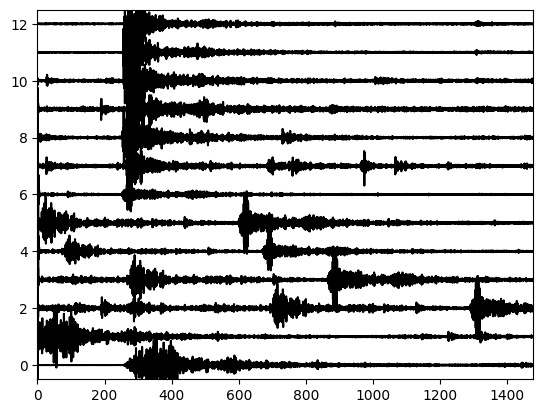

In [17]:
from mspasspy.algorithms.signals import filter,detrend
ensemble=detrend(ensemble,type='constant')
ensemble=filter(ensemble,'bandpass',freqmin=0.5,freqmax=2.0)
ensemble=scale(ensemble,method='rms',level=0.1)
plotter.plot(ensemble)

Both of the last two plots show that the first 7 aftershocks are mixed up in the coda of the mainshock.   Some studies would, of course, still be interested in those 7 events, but we will use this as an example of how to edit data at the source level.

In this case "editing the source data" can be accomplished by deleting records in source collection.  In this case, that can be done by a time range query operator.  The next box shows how to construct that and verify it does what we want it to do before using it to delete documents.

In [18]:
# get the mainshock origin time
doc=db.source.find_one({'magnitude' : {'$gt' : 9.0} } )
mainshock_ot=doc['time']
stime=mainshock_ot + 10.0  # add a fudge factor to sure exclusion of mainshock
etime=mainshock_ot + 4.0*3600.0  # four hours
query = { 'time' : {'$gt' : stime, '$lt' : etime} }
n_to_delete = db.source.count_documents(query)
print('Number source documents this operator will delete = ',n_to_delete)

Number source documents this operator will delete =  7


Notice the form of the interval query.  It is a typical range query for MongoDB.  We used `count_documents` to verify the number resolved matches what we were after.  That is a simple test, but when doing editing it is good practice to be paranoid. 

Now apply this to delete those source records and then verify the result is what we expected (compare the output to above):

In [19]:
db.source.delete_many(query)
cursor=db.source.find({}).sort('time')
for doc in cursor:
    print(UTCDateTime(doc['time']),doc['magnitude'])

2011-03-11T05:46:23.200000Z 9.1
2011-03-11T11:36:40.030000Z 6.5
2011-03-11T19:46:35.300000Z 6.5
2011-03-12T01:47:16.160000Z 6.5
2011-04-07T14:32:44.100000Z 7.1
2011-04-11T08:16:12.690000Z 6.7


That did what we asked wanted.  There is a residual cleanup one might need to do in applying this to a larger dataset.  That is, the waveform data for the 7 events we just deleted is now an orphan.  You have the files but they will be ignored for the rest of this tutorial.   The generic problem of file handling is outside the scope of this tutorial. We point out only the MsPASS does have tools to simplify file cleanup, but there aren't applicable for this example.

## Windowing Data

The time scale we have in the plot above is largely useless;  it is just an arbitrary offset from the origin time for each event.   In this section we will illustrate the common processing step in dealing with teleseismic data where we need to extract a smaller time window around a phase of interest.  

For illustration of the concepts, this section will use only a subset of vertical component data from the mainshock.  Later we will do something similar for the entire remaining data, but the smaller subset is easier to illustrate graphically.

The first step for illustration is to load the vertical components of the mainshock from all recording stations into a working ensemble.   To do that, we first have to define a query method to extract only the data we want.   This will be a step you will nearly alway need to address in handling teleseismic data.  The previous examples and the steps below are a start, but we reiterate that if you become a serious user of MsPASS you will need to become familiar with the pymongo API.   Our documentation covers many of the essentials, but MongoDB is a large, heavily-used package with a lot of features.  Google is your friend with MongoDB and it is relatively easy to find answers to almost any question about usage.

With that lecture we need to query the "source collection" to find data we 
need to select mainshock waveforms.   The mainshock is unique as the only event in this collection with a magnitude of 9 so we use that as a basis for the query.  We will then use the same query we just used above to find it's origin time.  We double check this resolves as we expect with a print.

In [20]:
query={'magnitude' : {'$gt' : 9.0}}
projection={'time' : True, 'magnitude' : True}
doc=db.source.find_one(query,projection)
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "65db41355e395d0be81037e8"
  },
  "time": 1299822383.2,
  "magnitude": 9.1
}


Now in the data download section we stated the start times of all waveforms in this data set are "763 s - 4 minutes" after the origin time of each event. The following uses that detail to construct a range query for waveforms where the start time is within + or - 1 s of that computed time.  Start times of data are generally a bit irregular.  How much depends upon how the input was created.  1 s is generous for these data. 

In [21]:
source_id = doc['_id']  # useful to save this
origin_time=doc['time']  # from immediately above
t_to_query = origin_time + 763.0 - 4.0*60.0
dt_for_test=1.0
tmin=t_to_query-dt_for_test
tmax=t_to_query+dt_for_test
query={'starttime' : {'$gt': tmin,'$lt' : tmax }}
# query is a python dict so we can add to an additional criteria like this
query['chan']='BHZ'
print('Time query to send to MongoDB server:')
print(query)
n=db.wf_miniseed.count_documents(query)
print('Number of waveforms for this event=',n)

Time query to send to MongoDB server:
{'starttime': {'$gt': 1299822905.2, '$lt': 1299822907.2}, 'chan': 'BHZ'}
Number of waveforms for this event= 437


As noted earlier, testing a complex query like the one above with MongoDB's `count_documents` method is always a good idea when you are developing a workflow.  It is too easy to make a simple mistake that will yield no results or the wrong result.  This is another, typical example. 

Now let's load and plot some of the waveforms.  The entire set is too huge for a single plot with SeismicPlotter so we will limit the number we extract to 15.  

Size of ensemble being plotted= 15


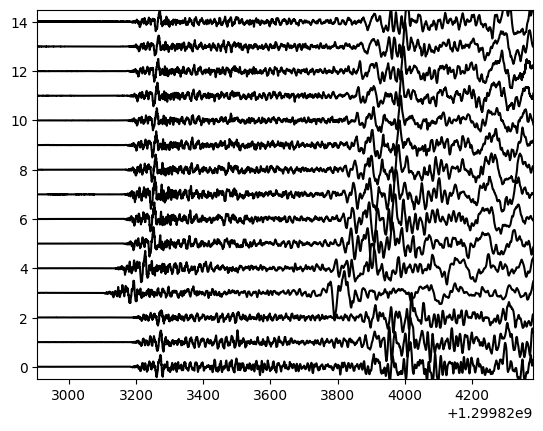

In [22]:
cursor = db.wf_miniseed.find(query).limit(15)
ensemble = db.read_data(cursor, collection='wf_miniseed')
ensemble=detrend(ensemble,type='constant')
ensemble=scale(ensemble)   # this time use default scaling by peak amplitude
print("Size of ensemble being plotted=",len(ensemble.member))
plotter.plot(ensemble)

Some things you should learn from this example working from the top down:
1.  With pymongo a query is constructed as a python dict.   Equality matches are implied by  constructs like `query['chan']='BHZ'`.  The starttime construct is more elaborate but note the key to the dict is *starttime* and the value associated with the key is itself a dict.  Note again that the concept of what MongoDB calls a "document" maps exactly into a python dict container.  A first order feature is that MongoDB's query language uses documents (dictionaries) to define the query language.  That will be very foreign to Antelope or SQL users.  MongoDB would call the dict container that is the value associated with *starttime* a "subdocument".  The construct used for the *starttime* query uses MongoDB operators as the keys in the subdocument.  The operators are keywords that begin with the dollar sign ($) symbol.   There is a long list of operators that can be found in various MongoDB online sources [like this one.](https://docs.mongodb.com/manual/reference/operator/query/>)
2.  We constructed our query dictionary (`query`) in two steps.  That isn't required.  We did it just to illustrate that a query can often best be constructed from a core set that can be defined with an incantation using curly brackets, colons, constants, and python variables.  That programming trick is not discussed in most tutorials.
3.  We load the ensemble with essentially the same mechanism as above but with a different query.
4.  We applied the lesson learned above to apply a detrend function to remove the dc component of each ensemble member.

The last thing the above box does is plot the data. From the output see the data are again in UTC time and the data are not aligned because there is no correction for variations in receiver position.   Recall we used only the origin time to define the time window of window to download.  The USArray stations in the plot cover a large area so there are large variations in arrival time relative to the constant offset we used for downloading the data. The next step is then to convert the data to relative time and align the data on the predicted P wave arrival time.  The first step to do that is to associate each TimeSeries object with the receiver metadata of the instrument that that recorded the data.  Because these data came from an FDSN data center (IRIS) a given channel of data is uniquely defined by the four magic SEED code names referred to as network, station, channel, and location.  In the standard MsPASS schema these are shortened to *net*, *sta*, *chan*, and *loc* respectively. The next section discuss this in terms a generic concept MongoDB calls "normalization".  

## Data Normalization
Data normalization is MongoDB's approach to what is called a "join" in relational database theory.   Relational databases (e.g. Antelope) are usually carefully designed to make some "join" operators as fast as possible.  An example in the CSS3.0 schema used by Antelope is joining "wfdisc" table tuples to "site" tuples.   In CSS3.0 databases that operation is used to link station coordinates to each waveform.   MongoDB is not a relational database but defines the same concept as "normalization".   We use `channel` and `site` collections to fill the roll of several CSS3.0 tables in a single "collection".  We also use a `source` collection in place of several source related tables in CSS3.0. The purpose of all is to put small amounts of information that are shared by many waveforms in a single, organized place that MongoDB calls a "collection".   We created `source`, `channel`, and `site` collections for this tutorial at the beginning of this notebook.

We have found that a pure database approach to handling MongoDB normalization is slow and can be a bottleneck in handling large data sets.   For that reason we developed multiple ways of handling the "normalization" problem.   The workflow below illustrates the two primary mechanisms we have found as a best practice for working with MsPASS.   The box below processes all the data and illustrates all the main aspects of normalization.   The results are only summarized and nothing is actually saved there.  The section in this tutorial will repeat this same process, do some more things, and then save first-level processed data managed by the database. 

As above we suggest you run this code box and then refer to below to discuss what it does and what it should teach you.

In [23]:
from mspasspy.db.normalize import (normalize,
                                   MiniseedMatcher,
                                   ObjectIdMatcher)
from mspasspy.ccore.utility import ErrorSeverity,MsPASSError
# These two gizmos cache channel and source data are do the normalizations
# below.   They cache the contents of channel and source respectively 
# for efficiency
station_normalizer = MiniseedMatcher(db)
source_normalizer = ObjectIdMatcher(db,
                            collection='source',
                            attributes_to_load=['_id','lat','lon','depth','time','magnitude'],
                        )
i = 0  # counter used only for printing at bottom of this loop
cursor=db.source.find({})  # we process all remaining events
for doc in cursor:
    origin_time=doc['time']
    t_to_query = origin_time + 763.0 - 4.0*60.0
    dt_for_test=1.0
    tmin=t_to_query-dt_for_test
    tmax=t_to_query+dt_for_test
    query={'starttime' : {'$gt': tmin,'$lt' : tmax },
      'chan' : 'BHZ',
      }
    # method 1:   normalize each member during read using miniseed matching
    cursor=db.wf_miniseed.find(query)
    ensemble=db.read_data(cursor,
                      collection='wf_miniseed',
                      normalize=[station_normalizer],
                     )
    print(len(ensemble.member))
    # method 2:  normalize source data by ensemble
    # in this example we do that by ObjectId of the source record
    srcquery={
        'time' : {'$gt' : origin_time-dt_for_test,
                  '$lt' : origin_time+dt_for_test}
    }
    srcdoc=db.source.find_one(srcquery)
    # demonstration of standard error handling in database queries
    if srcdoc is None:
        ensemble.kill()
        message="source query {} failed".format(str(srcquery))
        ensemble.elog.log_error("getting_started_script",
                                message,
                                ErrorSeverity.Invalid)
    else:
        # This particular algorithm is for demonstation only.  
        # if this algorithm were to be applied to large data set it would
        # be more efficient to just copy the contents of srcdoc directly 
        # to the ensemble Metadata container.  
        ensemble['source_id'] = srcdoc['_id']
        ensemble = normalize(ensemble,source_normalizer)
    # for this demo we just print a partial report of the result
    nm2print=6  # only print this many ensemble member contents
    print('Ensemble number ',i,' has live status set ',ensemble.live)
    print('Ensemble has ',len(ensemble.member),' live members')
    print('Source coordinates for this ensemble:')
    print(ensemble['source_lat'],
          ensemble['source_lon'],
          ensemble['source_depth'],
          UTCDateTime(ensemble['source_time']),
         )
    print('partial Metadata content of first ',nm2print,' members')
    for i in range(nm2print):
        # a convenient shorthand symbol but not essential 
        d = ensemble.member[i]
        if d.live:
            print(d['net'],
                d['sta'],
                d['chan'],
                d['channel_lat'],
                d['channel_lon'],
                d['channel_elev'],
                 )
    i += 1
    
    

427
Ensemble number  0  has live status set  True
Ensemble has  427  live members
Source coordinates for this ensemble:
36.9529 140.5842 13.3 2011-04-11T08:16:12.690000Z
partial Metadata content of first  6  members
TA 034A BHZ 27.064699 -98.683296 0.155
TA 035A BHZ 26.937901 -98.102303 0.029
TA 035Z BHZ 26.462999 -98.068298 0.019
TA 109C BHZ 32.888901 -117.105103 0.15
TA 121A BHZ 32.532398 -107.785103 1.652
TA 133A BHZ 32.608299 -98.916199 0.418
429
Ensemble number  6  has live status set  True
Ensemble has  429  live members
Source coordinates for this ensemble:
38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
partial Metadata content of first  6  members
TA 034A BHZ 27.064699 -98.683296 0.155
TA 035A BHZ 26.937901 -98.102303 0.029
TA 035Z BHZ 26.462999 -98.068298 0.019
TA 109C BHZ 32.888901 -117.105103 0.15
TA 121A BHZ 32.532398 -107.785103 1.652
TA 133A BHZ 32.608299 -98.916199 0.418
436
Ensemble number  6  has live status set  True
Ensemble has  436  live members
Source coordinat

There are a lot unrelated, useful tricks in the above box, but the main point initially are the two sections lighlighted as "Method 1" and "Method 2".  Details on what each do is worth emphasis here.  More details on this topic can be found in the [User's Manual](https://mspass.org).

*Method 1 section*.   The example shows a "normalize on read" approach to normalization.  The process is handled by a python object (class) we created at the top of the box called a `MiniseedMatcher`.  Details on this object can be found by reading the docstring for the class.  The basic idea, however, is that when the contents of the  `station_normalizer` are created the entire "channel" collection will be loaded into memory and indexed.   The index uses the miniseed station codes and time ranges.  It should be obvious this approach only makes sense if the size of the channel collection is not huge.   In our experience, for passive array data that is always true.   We can imagine examples where that model may be wrong (e.g. DAS data) so we note there is also a `MiniseedDBmatcher` that accomplishes the same thing using database transactions and a special function called `normalize_mseed` that can be used to create cross-references to every record in a `wf_miniseed` collectin.   In any case, what the code above does do the net:sta:chan:time matching for each ensemble member while each member is being loaded.  Note from the print section that the relevant Metadata fields are preceeded by the magic string "channel_" (e.g. "channel_lat", "channel_lon", etc.).  This script demonstrates why that is necessary as the same data are also associated with "source_lat" and "source_lon";  "lat" or "lon" alone would be ambiguous names.   

*Method 2 section*.  This section demonstrates another way to do normalization where the normalization data are loaded after a datum is "constructed" to use a jargon term.  This particular example is much more complex than the way one should normally do this task.  You should look at examples in the User's Manual for more common ways to do this process.  The complication, in this case, is we had not previously done cross-referencing needed to define normalization.   Here we are doing that cross-referencing on the fly rather than build a cross reference beforehand.  That is, we could have done this same thing by running a script to set the attribute "source_id" in each document in `wf_miniseed`.   (We will actually do that in a box below to prep the dataset for a parallel processing run.)  The algorithm here is actually more efficient for large ensembles like this where there are hundreds of waveforms associated with each source "document".  The example uses the `ObjectIdMatcher` (symbol `source_normalizer`) to load a subset of Metadata from each "source collection" document to each ensemble's Metadata container.  As with channel data the attributes get the prefix "source_" to assure the Metadata keys are unique.  Note the way we used `source_normalizer` was actually not necessary as we could have extracted the attributes we needed document with the symbol `srcdoc`.  What we did was stringly for instructional purposes and it is not most efficient way to do that task.

## Processing Workflow 
Finally, we illustrate an example workflow.   In this notebook, which was designed to be run on a typical desktop system, we limit the processing to a serial workflow.   A followup to this one called "parallel_processing_basics.ipynb" uses the output of this notebook to do additional work in parallel.  
### Processing steps
The example here aims to process the data set we downloaded with the following sequence of steps repeated for every waveform in this dataset:
1.  Load the data and build the internal mspass data objects we call TimeSeries.  We normalize the channel data while reading.
2.  Normalize the data to load source coordinates.
3.  Demean each datum
4.  Resample all data to 20 sps.
5.  Compute model-based P and S wave arrivals times and load the times into the data headers.
6.  Save the results to the core processing collection called "wf_TimeSeries".

These are typical "preprocessing" steps to regularize a set of teleseismic waveforms for some form of event-based processing.     


In [24]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import detrend
from mspasspy.algorithms.basic import ator
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.db.normalize import (normalize,
                                   MiniseedMatcher,
                                   OriginTimeMatcher)
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.resample import (ScipyResampler,
                                          ScipyDecimator,
                                          resample,
                                         )
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
import time

def set_PStime(d,Ptimekey="Ptime",Stimekey="Stime",model=None):
    """
    Function to calculate P and S wave arrival time and set times 
    as the header (Metadata) fields defined by Ptimekey and Stimekey.
    Tries to handle some complexities of the travel time calculator 
    returns when one or both P and S aren't calculatable.  That is 
    the norm in or at the edge of the core shadow.  
    
    :param d:  input datum.  Type is not checked and is assumed 
      to be a TimeSeries.  It also must contain source coordinates 
      and "channel" based coordinates (i.e.  channel_lat, channel_lon,
      and channel_elev) or the datum will be killed.  This algorithm 
      assumes these are already set because in this workflow 
      normalization methods will kill any datum for which they 
      couldn't be loaded.
    :param Ptimekey:  key used to define the header attribute that 
      will contain the computed P time.  Default "Ptime".
    :param model:  instance of obspy TauPyModel travel time engine. 
      Default is None.   That mode is slow as an new engine will be
      constructed on each call to the function.  Normal use should 
      pass an instance for greater efficiency.  
    """
    if d.live:
        if model is None:
            model = TauPyModel(model="iasp91") 
        srclat=d["source_lat"]
        srclon=d["source_lon"]
        srcz=d["source_depth"]
        srct=d["source_time"]
        stalat=d["channel_lat"]
        stalon=d["channel_lon"]
        staelev=d["channel_elev"]
        georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
        # obspy's function we just called returns distance in m in element 0 of a tuple
        # their travel time calculator it is degrees so we need this conversion
        dist=kilometers2degrees(georesult[0]/1000.0)
        arrivals=model.get_travel_times(source_depth_in_km=srcz,
                                            distance_in_degree=dist,
                                            phase_list=['P','S'])
        # always post this for as it is not cheap to compute
        # WARNING:  don't use common abbrevation delta - collides with data dt
        d['epicentral_distance']=dist
        # these are CSS3.0 shorthands s - station e - event
        esaz = georesult[1]
        seaz = georesult[2]
        d['esaz']=esaz
        d['seaz']=seaz
        # get_travel_times returns an empty list if a P time cannot be 
        # calculated.  We trap that condition and kill the output 
        # with an error message
        if len(arrivals)==2:
            Ptime=srct+arrivals[0].time
            Stime=srct+arrivals[1].time
            d.put(Ptimekey,Ptime)
            d.put(Stimekey,Stime)
        elif len(arrivals)==1:
            if arrivals[0].name == 'P':
                Ptime=srct+arrivals[0].time
            else:
                # Not sure we can assume name is S
                if arrivals[0].name == 'S':
                    Stime=srct+arrivals[0].time
                else:
                    message = "Unexpected single phase name returned by taup calculator\n"
                    message += "Expected phase name S but got " + arrivals[0].name
                    d.elog.log_error("set_PStime",
                                     message,
                                     ErrorSeverity.Invalid)
                    d.kill()
                
        else:
            message="Cannot calculate a travel time for this datum\n"
            message="epicentral distance={} is likely problem".format(str(dist))
            d.elog.log_error("set_PStime",message,ErrorSeverity.Invalid)
            d.kill()
        return d
            
ttmodel = TauPyModel(model="iasp91")
channel_normalizer = MiniseedMatcher(db)
# For this run we also want to build a cross-reference to the site 
# collection.  It will help us later in 3C processing.  
site_normalizer = MiniseedMatcher(db,
                                  collection='site',
                                 attributes_to_load=['_id',
                                                    'net',
                                                    'sta',
                                                    'starttime',
                                                    'endtime',
                                                    'lat',
                                                    'lon',
                                                    'elev'])

# we loaded data with this offset relative to origin time - used below
t0offset=763.0 - 4.0*60.0  
resampler=ScipyResampler(20.0)
decimator=ScipyDecimator(20.0)
stime=-100.0
etime=500.0    
cursor = db.wf_miniseed.find({})  # this is a loop over the full dataset
t0 = time.time()
nlive=0
ndead=0
cursor=db.source.find({})  # we process all remaining events
for doc in cursor:
    # construct a waveform query as a time range around the 
    # expected start time - similar to earlier
    otime = doc['time']
    ottest = otime + t0offset
    wfquery = {'starttime' : { '$gt' : ottest-1.0, '$lt' : ottest+1.0} }
    wfcursor = db.wf_miniseed.find(wfquery)
    ensemble = db.read_data(wfcursor, 
                            collection='wf_miniseed',
                            normalize=[channel_normalizer,site_normalizer],
                           )
    # We normalize the ensemble a more efficient way here 
    # we just load attributes from doc into the ensemble's Metadata container
    
    # This section is a workaround until OriginTimeMatcher is fixed
    ottest=d.t0-t0offset
    for k in ['lat','lon','depth','time']:
        newkey="source_" + k
        ensemble[newkey]=doc[k]
        # handle source_id specially
        ensemble['source_id']=doc['_id']
    ensemble = detrend(ensemble,type="constant")
    ensemble = resample(ensemble,decimator,resampler)
    # our special function defined works on atomic data 
    # this is a typical way to process the ensemble with such a function
    # a weird property of python makes the indexed array for necessary
    # in this context
    for i in range(len(ensemble.member)):
        ensemble.member[i] = set_PStime(ensemble.member[i],model=ttmodel)
        if ensemble.member[i].live:
            nlive += 1
        else:
            ndead += 1
    db.save_data(ensemble,data_tag='preprocessed')
t=time.time()    
print("Total processing time=",t-t0)
print("Number of live data saved=",nlive)
print("number of data killed=",ndead)

/tmp/ipykernel_207/2998617969.py:49: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)


Total processing time= 200.72125005722046
Number of live data saved= 7803
number of data killed= 3
